<a href="https://colab.research.google.com/github/tinahuang222/NucleiSegmentation/blob/master/PREPROCESSING/ColorConvolve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
%matplotlib inline

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

from PIL import Image  

import json
import pandas as pd

import csv

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import pickle

!pip3 install histomicstk
import histomicstk as htk
#specific versions required for downloaded code segments
#!pip3 install -q scipy==1.2.0
#!pip3 install -q imgaug==0.2.6


################################################################################
# Read Data from google drive
################################################################################
from google.colab import drive #for loading gdrive data
drive.mount('/content/gdrive')

###                     MAIN DIRECTORY NAMES
gdir = '/content/gdrive/My Drive/'
main_directory = gdir

#
#directory of top level of user data
#

use_pickle = 1  #use pre-saved pickle data insted of reprocessing data
use_mask_pickle = 1
use_centroid_pickle = 1
use_he_pickle = 1
use_h_glcm_pickle = 1 #use saved GLCM data
use_e_glcm_pickle = 1

feature_folder = os.path.join(gdir,'FEATURE_EXTRACTION')
original_image_folder = os.path.join(feature_folder,'tiles_rois','original')

tiles_dir = os.path.join(feature_folder,'tiles_rois','normalized')
tile_melanomas_dir = os.path.join(gdir,feature_folder,'tile_melanomas_examples')
tile_label_dir = os.path.join(gdir,feature_folder,'tiles_rois')
#mask_dir = os.path.join(gdir,'masks')

preprocess_dir = os.path.join(gdir,'TILE_PREPROCESSING')
outputs_main_dir = os.path.join(preprocess_dir,'PREPROCESSING','OUTPUTS') #upper level for outputs
patch_review_dir = os.path.join(outputs_main_dir,'PATCH_REVIEW')

original_output_dir = os.path.join(gdir,'TILE_PREPROCESSING','ORIGINAL_TO_HE')
percent_stain_output_dir = os.path.join(gdir,'TILE_PREPROCESSING','PERCENT_STAIN')
stain_region_output_dir = os.path.join(gdir, 'TILE_PREPROCESSING','STAIN_PERCENT_REGIONS')

#512x512 CSV mask points, easier to use than the full image masks
mask_dir = os.path.join(gdir,'TILE_PREPROCESSING','masks_512x512') #'masks_npy')
centroid_dir = os.path.join(gdir,'TILE_PREPROCESSING','centroids_512x512')

#
#pickle file used to store full image sets, which take more than a minute to run
#
pickle_file = os.path.join(preprocess_dir,'PICKLE_FILE.pck')
he_pickle_file = os.path.join(preprocess_dir,'PICKLE_FILE_HE_IMAGES.pck')
mask_pickle_file = os.path.join(preprocess_dir, 'PICKLE_FILE_MASK_DATA.pck')
centroid_pickle_file = os.path.join(preprocess_dir, 'PICKLE_FILE_CENTROID_DATA.pck')
#store H & E GLCM correlation and dissimilarity outputs
h_glcm_pickle_file = os.path.join(preprocess_dir, 'PICKLE_FILE_H_GLCM.pck')
#h_glcm_d_pickle_file = os.path.join(preprocess_dir, 'PICKLE_FILE_H_GLCM_D.pck')
e_glcm_pickle_file = os.path.join(preprocess_dir, 'PICKLE_FILE_E_GLCM.pck')
#e_glcm_d_pickle_file = os.path.join(preprocess_dir, 'PICKLE_FILE_E_GLCM_D.pck')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
'''
Get image files and load them into memory
'''


#get listing of image files in directory
image_files = os.listdir(original_image_folder)

image_names =[]
#store filenames without extension for output purposes later
for filename in image_files:
    root_ext = os.path.splitext(filename) #will return two parts, name and ext
    image_names.append(root_ext[0])


#resizing parameters for raw to final 
NX = 512
NY = NX

#open the images
image_data = {}
for fcounter,filename in enumerate(image_files):
    full_filename = os.path.join(original_image_folder,filename)
    #root_ext = os.path.splitext(filename)
    #tile_file = root_ext[0] + '.png'
    #    tile_roi_file = os.path.join(tiles_dir, tile_file)

    if ((fcounter % 100) == 0):
        print('Now at image # ', fcounter)
    
    image_data[fcounter] = Image.open(full_filename)
    image_data[fcounter] = image_data[fcounter].resize((NX, NY), Image.ANTIALIAS)
    

#review sample image
plt.figure(figsize=(17, 17))
plt.imshow(image_data[5])
plt.colorbar()
plt.show()

Now at image #  0


KeyboardInterrupt: ignored

In [0]:
'''
Save intermediate data to a pickle file. This should save some recomputing time
'''
if (use_pickle == 0):
    print('pickle file is ', pickle_file)
    with open(pickle_file, 'wb') as f:
        pickle.dump(image_data, f)

    print('Saved full image set to pickle file')
else:
    print('skipping pickle save for image data due to pickle load')

skipping pickle save for image data due to pickle load


In [0]:
'''
Load mask data for images. Masks are in npy format, shaped as
[nx,ny,#masks] where each mask is a 1024x1024 image
------ these mask images take 10GB memory, since they are full images. Use the 
newer set of data provided for 512x512
'''

if (use_mask_pickle == 0):
    mask_files = os.listdir(mask_dir)

    #prepare storage dictionaries for data from every file
    mask_tile = {}
    mask_id = {}
    mask_xx = {}
    mask_yy = {}
    for fcounter, filename in enumerate(mask_files):
        full_filename = os.path.join(mask_dir,filename)
        #print('Processing Mask File: ',filename)
        with open(full_filename) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            #next(csv_reader,none) #skip header row
            line_count = 0

            mask_tile[fcounter] =[]
            mask_id[fcounter] = []
            mask_xx[fcounter] = [] #init new list to hold all x,y data
            mask_yy[fcounter] = []
            for row in csv_reader:
                if line_count == 0:
                    #print(f'Column names are {", ".join(row)}')
                    line_count += 1
                else:
                    mask_tile[fcounter].append(row[0])
                    mask_id[fcounter].append(np.uint(row[1]))
                    mask_xx[fcounter].append(np.uint(row[2]))
                    mask_yy[fcounter].append(np.uint(row[3]))

                    #print('x and y ',row[0],row[1])
                    line_count += 1
            #print(f'Processed {line_count} lines.')


    mask_pickle_data = [mask_tile, mask_id, mask_xx, mask_yy]
    print('pickle file is ', mask_pickle_file)
    with open(mask_pickle_file, 'wb') as f:
        pickle.dump(mask_pickle_data, f)

    print('Saved full mask image set to pickle file')
else:
    print('loading mask data from pickle file')
    mask_tile, mask_id, mask_xx, mask_yy = pickle.load( open(mask_pickle_file, "rb" ) )
    print('Finished loading mask data from pickle file')

pickle file is  /content/gdrive/My Drive/TILE_PREPROCESSING/PICKLE_FILE_MASK_DATA.pck
Saved full mask image set to pickle file


In [2]:
'''
Use pre-processed mask centroid data

!!!! Ensure that the centroid file order matches the order of the image data
image_names[] can be used to sync them up, as image_names is the order of the 
image files read in.
'''




if (use_centroid_pickle == 0):

    centroid_files = os.listdir(centroid_dir)
    file_counter = 0 #inc for each file opened
    centroid_xx ={}
    centroid_yy = {}


    #there should be one centroid file for each image file, so use image_files 
    #to create a listing of files
    image_files = os.listdir(original_image_folder)

    image_names =[]
    #store filenames without extension for output purposes later
    for filename in image_files:
        root_ext = os.path.splitext(filename) #will return two parts, name and ext
        image_names.append(root_ext[0])
    centroid_sync_files = []
    for ii in range(0,len(image_names)):
        centroid_temp_file = image_names[ii] + '.csv'
        centroid_sync_files.append(centroid_temp_file)



    for fcounter,filename in enumerate(centroid_sync_files): #centroid_files):
    #    #open file and grab all csv data
        if ((fcounter % 100) == 0):
            print('Now Loading Centroid # ', fcounter)

        full_filename = os.path.join(gdir,'TILE_PREPROCESSING','centroids_512x512',filename)
        with open(full_filename) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            centroid_xx[fcounter] = [] #init new list to hold all x,y data
            centroid_yy[fcounter] = []
            for row in csv_reader:
                if line_count == 0:
                    #print(f'Column names are {", ".join(row)}')
                    line_count += 1
                else:
                    #print('row set: ', row)
                    #there is at least one row that is null characters, check 
                    #for those
                    if ( (row[0] == '') or (row[1] == '')):
                        print('found an empty row. Replacing with -values.', line_count, row)
                        row[0] = 0
                        row[1] = 0

                    centroid_xx[fcounter].append(np.uint(np.float(row[0])))
                    centroid_yy[fcounter].append(np.uint(np.float(row[1])))
                    #print('x and y ',row[0],row[1])
                    line_count += 1

    #finished putting all pickle data into dictionaries, save it to a pickle file
    centroid_pickle_data = [centroid_xx, centroid_yy]
    print('Centroid pickle file is ', centroid_pickle_file)
    with open(centroid_pickle_file, 'wb') as f:
        pickle.dump(centroid_pickle_data, f)

    print('Saved full mask image set to pickle file')
else:
    #load from a pickle file
    centroid_xx, centroid_yy = pickle.load( open( centroid_pickle_file, "rb" ))
    print('Loaded Centroid data from pickle file')


Loaded Centroid data from pickle file


In [0]:
print(row[0] == '')

True


In [3]:
'''
Get Cancer, No Cancer listing
'''

label_file = os.path.join(tile_label_dir,'dataset.csv')

#header row:
#slidename    title    label 

tile_roi_status={} #store filename and the cancer label

with open(label_file) as label_data:
    csv_reader = csv.reader(label_data, delimiter=',')
    line_count = 0

    for row in csv_reader:
        if line_count == 0:
                #print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            #print('row set: ', row)
            tile_roi_status[row[1]] = row[2]
            #tile_roi_label.append(row[2])

                #print('x and y ',row[0],row[1])
            line_count += 1
        #print(f'Processed {line_count} lines.')
print('Finished Loading Cancer, No Cancer Status Labels')

Finished Loading Cancer, No Cancer Status Labels


In [0]:
'''
Perform histomicsTK prep
'''
if (use_he_pickle == 0):

    #defaults for HE staining from HTK site
    # create stain to color map
    stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
    print('stain_color_map:', stain_color_map, sep='\n')

    # specify stains of input image
    stains = ['hematoxylin',  # nuclei stain
            'eosin',        # cytoplasm stain
            'null']         # set to null if input contains only two stains

    # create stain matrix
    W = np.array([stain_color_map[st] for st in stains]).T

    deconvolved_image_h={}
    deconvolved_image_e={}
    for ii,fcounter in enumerate(image_data):

        if ((fcounter % 100) == 0):
            print('Now Deconvolving image # ', fcounter)
        imInput = np.array(image_data[fcounter]) #convert to NP array format first
        # perform standard color deconvolution
        imDeconvolved = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, W)

        #store this output set in H and E dictionaries
        deconvolved_image_h[fcounter] = imDeconvolved.Stains[:,:,0]
        deconvolved_image_e[fcounter] = imDeconvolved.Stains[:,:,1]

    print('shape of imDeconvolved is ', np.shape(imDeconvolved))


In [0]:
'''
Save plots of the H and E data to drive. These are NOT useful for processing, as
they contain all the axes and other information from matplotlib (plots instead 
of images). Output image data is just saved to the pickle file
'''
for ii in range(0,len(deconvolved_image_h)):

    current_image_name = image_names[ii]

    plt.figure()
    plt.imshow(deconvolved_image_h[ii],cmap = 'gray')
    htitle = 'Hematoxylin_' + current_image_name + '_File#_'+ str(ii)
    hfile = htitle + '.png'
    hfile = os.path.join(original_output_dir,hfile);
    plt.colorbar()
    plt.title(htitle)
    plt.savefig(hfile, format='png',dpi=300, bbox_inches='tight')

    plt.figure()
    plt.imshow(deconvolved_image_e[ii],cmap = 'gray')
    etitle = 'Eosin_' + current_image_name + '_File#_'+ str(ii)
    efile = etitle + '.png'
    efile = os.path.join(original_output_dir,efile);
    plt.colorbar()
    plt.title(etitle)
    plt.savefig(efile, format='png',dpi=300, bbox_inches='tight')


    if ((ii % 100) == 0):
        print('Now Writing Deconvolved Image to GDRIVE:# ', ii)


    plt.close('all')


Now Writing Deconvolved Image to GDRIVE:#  0
Now Writing Deconvolved Image to GDRIVE:#  100
Now Writing Deconvolved Image to GDRIVE:#  200
Now Writing Deconvolved Image to GDRIVE:#  300
Now Writing Deconvolved Image to GDRIVE:#  400
Now Writing Deconvolved Image to GDRIVE:#  500
Now Writing Deconvolved Image to GDRIVE:#  600
Now Writing Deconvolved Image to GDRIVE:#  700
Now Writing Deconvolved Image to GDRIVE:#  800
Now Writing Deconvolved Image to GDRIVE:#  900


In [4]:
'''
Save HE data to a pickle file. This should save some recomputing time and
won't have all the matplotlib overlaying data
'''
#packaging up the two H & E datasets for pickle storage

if (use_he_pickle == 0):
    he_data = [deconvolved_image_h,deconvolved_image_e, image_names]
    print('pickle file is ', he_pickle_file)
    with open(he_pickle_file, 'wb') as f:
        pickle.dump(he_data, f)

    print('Saved full HE image set to pickle file')
else:
    #load the data
    deconvolved_image_h,deconvolved_image_e, image_names = pickle.load( open( he_pickle_file, "rb" ) )
    print('Loaded deconvolved images from pickle')

Loaded deconvolved images from pickle


In [0]:
# Test out pickle load 
#if (use_he_pickle == 1):
    #he_pickle_file = /content/gdrive/My Drive/TILE_PREPROCESSING/PICKLE_FILE_HE_IMAGES.pck
#    deconvolved_image_h,deconvolved_image_e, image_names = pickle.load( open( he_pickle_file, "rb" ) )

NameError: ignored

In [0]:
'''
Statistics on h and e images
'''


#
# GLCM
#
from skimage.feature import greycomatrix, greycoprops


xs_h = []
ys_h = []

for fkey in deconvolved_image_h:
    glcm = greycomatrix(deconvolved_image_h[fkey],
                        distances=[25],
                        angles=[0],
                        levels=256,
                        symmetric=True,
                        normed=True)
    xs_h.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys_h.append(greycoprops(glcm, 'correlation')[0, 0])



xs_e = []
ys_e = []

for fkey in deconvolved_image_e:
    glcm = greycomatrix(deconvolved_image_e[fkey],
                        distances=[25],
                        angles=[0],
                        levels=256,
                        symmetric=True,
                        normed=True)
    xs_e.append(greycoprops(glcm, 'dissimilarity')[0, 0])
    ys_e.append(greycoprops(glcm, 'correlation')[0, 0])





[0.0936126669030063, 0.03385186989349299, 0.16898505611983938, 0.20026753973074224, 0.08967113870529864, 0.30330699449346865, 0.15258378300478823, 0.14273290250846854, 0.10339804128618417, 0.42617742037882395, 0.1450087011448374, 0.12283188670878875, 0.06908042898189087, 0.14828288258746583, 0.1598558732851172, 0.05647567905969192, 0.0426466661696292, 0.07199003870618323, 0.13038273657859142, 0.1802754375334244, 0.05036395601075433, 0.2877153273403021, 0.08870417167226359, 0.10580671695488661, 0.1460506643794612, 0.15550060749043854, 0.18445896478425639, 0.08722229899920524, 0.30583558681651146, 0.11343908815771357, 0.11369740314460948, 0.09064637741055633, 0.4403484798613279, 0.06969793278097167, 0.36554405382726696, 0.09816991405353537, 0.08736315482898666, 0.20951357259345973, 0.26379703402709986, 0.0867699728361372, 0.09417441171222993, 0.26491161164970645, 0.3894307317817283, 0.19371234271902577, 0.20832696052409902, 0.043847271106617784, 0.0741404029208274, 0.1304636807187786, 0.

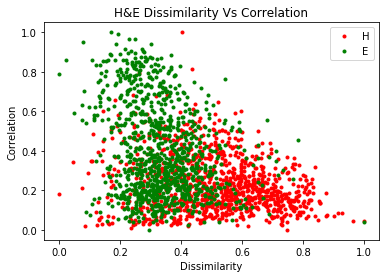

In [0]:
print(ys_h)
ynew=[]
ymin = np.min(ys_h)
ymax = np.max(ys_h)
for fkey in range(0,len(ys_h)):
    ynew.append( (ys_h[fkey] - ymin)/(ymax - ymin)) 

xmin = np.min(xs_h)
xmax = np.max(xs_h)
xnew=[]
for ii in xs_h:
    xnew.append( (ii - xmin)/(xmax - xmin)) 


plt.figure()
plt.plot(xnew,ynew, 'r.')
plt.xlabel('Dissimilarity')
plt.ylabel('Correlation')
plt.title('H&E Dissimilarity Vs Correlation')


#plotting E and H together requires the dissimilarity be normalized to 1

ymin = np.min(ys_e)
ymax = np.max(ys_e)
ynew=[]
for ii in ys_e:
    ynew.append( (ii - ymin)/(ymax - ymin)) 

xmin = np.min(xs_e)
xmax = np.max(xs_e)
xnew=[]
for ii in xs_e:
    xnew.append( (ii - xmin)/(xmax - xmin)) 

#plt.figure()
plt.plot(xnew,ynew, 'g.')
plt.legend(('H','E'))
#plt.xlabel('Dissimilarity')
#plt.ylabel('Correlation')
#plt.title('E Dissimilarity Vs Correlation')


In [0]:
'''
Positive Staining
'''

stain_percent ={}
for ii in range(0,len(deconvolved_image_h)):

    current_image_name = image_names[ii]

    #plt.figure()
    #plt.imshow(deconvolved_image_h[ii],cmap = 'gray')
    #plt.colorbar()

    #get intensities of H shown
    minval = np.min(deconvolved_image_h[ii])
    maxval = np.min(deconvolved_image_h[ii])
    ranges = maxval/4  # number of ranges of positive uptake

    index0 = np.where( deconvolved_image_h[ii] <= 60)
    index1 = np.where(np.logical_and(deconvolved_image_h[ii]>60,deconvolved_image_h[ii] <=120)) #  np.logical_and(a>=6, a<=10))
    index2 = np.where(np.logical_and(deconvolved_image_h[ii]>120,deconvolved_image_h[ii] <=180)) 
    index3 = np.where(np.logical_and(deconvolved_image_h[ii]>180,deconvolved_image_h[ii] <=256)) 
    #index2 = np.where( deconvolved_image_h[ii] > 60 and deconvolved_image_h[ii] <=120)
    ppi = np.zeros((512,512))
    ppi[index0] = 0
    ppi[index1] = 1
    ppi[index2] = 2
    ppi[index3] = 3


    percent_stained=[]
    for jj in [index0,index1, index2, index3]:
        percent_stained.append(len(jj[0])/(512*512) * 100.0)
    #print('Stain Region name & %: ', current_image_name, percent_stained)
    stain_percent[current_image_name] =  percent_stained


    #get cancer status
    cancer_status = tile_roi_status[current_image_name]
    if (cancer_status == '0'):
        cancer_label = 'No_Cancer'
    else:
        cancer_label = 'Cancer'


    # make a color map of fixed colors
    from matplotlib import colors
    colormap = colors.ListedColormap(['white', 'red','green','blue'])
    bounds=[0,60,120,180]
    norm = colors.BoundaryNorm(bounds, colormap.N)

    plt.figure()
    plt.imshow(deconvolved_image_h[ii],cmap=colormap)
    plt.colorbar()
    ename = 'Stain_Region_File_' + str(ii) + '_'+ current_image_name + '_' + cancer_label +'.png'
    efile = os.path.join(stain_region_output_dir,ename)
    plt.savefig(efile, format='png',dpi=300, bbox_inches='tight')
    plt.close('all')


In [43]:
'''
Calculate Stain Percentage averages
'''
r0 =[]
r1=[]
r2=[]
r3=[]
for ikey in stain_percent:
    r0.append(stain_percent[ikey][0])
    r1.append(stain_percent[ikey][1])
    r2.append(stain_percent[ikey][2])
    r3.append(stain_percent[ikey][3])

print('region 0 mean is ', np.mean(r0))
print('region 1 mean is ', np.mean(r1))
print('region 2 mean is ', np.mean(r2))
print('region 3 mean is ', np.mean(r3))




region 0 mean is  5.35687141418457
region 1 mean is  11.161845397949218
region 2 mean is  28.18120918273926
region 3 mean is  55.30007400512695


Now Writing Percent Stained Image to GDRIVE:#  0


SystemError: ignored

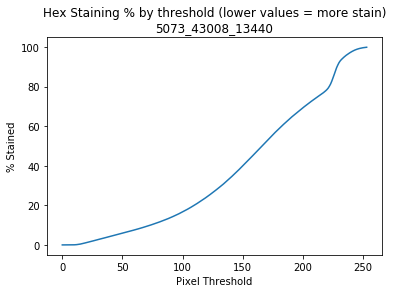

In [0]:

total_pixels = 512*512
for ii in range(0,len(deconvolved_image_h)):
    current_image_name = image_names[ii]



    percent_stained=[]
    for threshold in range(1,255):
        index = np.where(deconvolved_image_h[ii] <= threshold)
        percent_stained.append(len(index[0])/total_pixels * 100.0)

    plt.figure()
    plt.plot(percent_stained)
    plt.ylabel('% Stained')
    plt.xlabel('Pixel Threshold')
    stitle = 'Hex Staining % by threshold (lower values = more stain)\n' + current_image_name
    plt.title(stitle)
    ename = 'Percent_Stain_File_' + str(ii) + '_'+ current_image_name + '.png'
    efile = os.path.join(percent_stain_output_dir,ename)
    plt.savefig(efile, format='png',dpi=300, bbox_inches='tight')


    if ((ii % 100) == 0):
        print('Now Writing Percent Stained Image to GDRIVE:# ', ii)
    plt.close('all')

len(deconvolved_image_h[0])

Now Writing Percent Stained Image to GDRIVE:#  0
Now Writing Percent Stained Image to GDRIVE:#  100
Now Writing Percent Stained Image to GDRIVE:#  200
Now Writing Percent Stained Image to GDRIVE:#  300
Now Writing Percent Stained Image to GDRIVE:#  400
Now Writing Percent Stained Image to GDRIVE:#  500
Now Writing Percent Stained Image to GDRIVE:#  600
Now Writing Percent Stained Image to GDRIVE:#  700
Now Writing Percent Stained Image to GDRIVE:#  800
Now Writing Percent Stained Image to GDRIVE:#  900
H GLCM Corr and Dis. pickle file is  /content/gdrive/My Drive/TILE_PREPROCESSING/PICKLE_FILE_H_GLCM.pck
Saved full H CORR & DISS. Data to pickle file


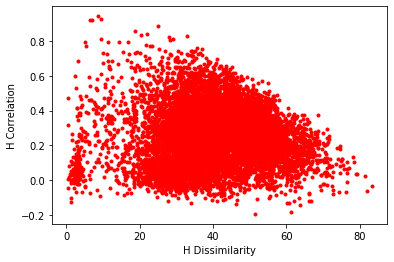

In [0]:
'''
Get patches for H 
need: H images, masks or mask centroids
'''
from matplotlib.patches import Rectangle
#
# GLCM
#
from skimage.feature import greycomatrix, greycoprops


#one side dimensions of the patches to cut out
patch_x = 25
patch_y = patch_x
#maximum border entry/exit locations
max_x = 512 - patch_x
min_x = patch_x
max_y = 512 - patch_y
min_y = patch_y
#number of patches/image
num_patches = 15

h_patch = {}
e_patch = {}
h_glcm_d = []   #store all of the glcm results for glcm
h_glcm_c = []
h_glcm_contrast =[]
h_glcm_energy = []
h_glcm_homogeneity =[]
h_image_names =[] #hold all of the filenames used
h_patch_status =[] #is this patch cancer or not

for ii in range(0,len(deconvolved_image_h)):
    current_image_name = image_names[ii]
    h_image_names.append(current_image_name) #store filename marker

    patch_list = []

    if ((ii % 100) == 0):
        print('Now Writing Percent Stained Image to GDRIVE:# ', ii)

    #we want patches centered around the mask blocks and areas away from the blocks
    number_centroids = range(0,len(centroid_xx[ii])) #number of masks in this file
    if (len(number_centroids) > num_patches):
        sample_ids = random.sample(set(number_centroids),num_patches)
    else:
        print('Not enough different centroids available here: ',ii)
        continue
    #now that we have centroids to use, get a patch from that
    #make sure we're not using a centroid near an edge that can go outside the
    #image area
    plt.figure() #one figure to hold the patches
    plt.imshow(deconvolved_image_h[ii])
    for id in sample_ids:
        #ensure that making a patch abou the centroid won't take us over border
        if (  ((centroid_xx[ii][id] - patch_x) >= min_x) and ( (centroid_xx[ii][id] + patch_x) <= max_x) and 
            ((centroid_yy[ii][id] - patch_y) >= min_y) and ((centroid_yy[ii][id] + patch_y) <= max_y)):
            #if this value won't spill over, keep going and get patches
            ax = plt.gca()
            
            # Create a Rectangle patch
            lowerx = centroid_xx[ii][id] - patch_x
            lowery = centroid_yy[ii][id] - patch_y

            boxlength = 50
            rect = Rectangle((lowerx,lowery),boxlength,boxlength,linewidth=2,edgecolor='r',facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
            

            ax.plot(centroid_xx[ii][id],centroid_yy[ii][id],'ko',
                    ms=14,
                    markerfacecolor="None",
                    markeredgecolor='k', markeredgewidth=2)
            tname = 'Patches for ' + current_image_name + '\n' + 'H Staining'
            plt.title(tname)


            #store the patch image data
            #center point is centroid, get image data +- xy from this and save
            #that to an array
            patch_data = deconvolved_image_h[ii][np.uint(centroid_xx[ii][id]-patch_x):np.uint(centroid_xx[ii][id] + patch_x),
                                                 np.uint(centroid_yy[ii][id]-patch_y):np.uint(centroid_yy[ii][id] + patch_y)]
            patch_list.append(patch_data)


        else:
            #this centroid value would have extended out of the image
            #print('border coordinate found. Skipping')
            continue

        #now we should have a set of patches to do GLCM on
        patch_d = []
        patch_corr = []
        patch_contrast = []
        patch_energy = []
        patch_homogeneity =[]

        for patch in patch_list:
            glcm = greycomatrix(patch,
                                distances=[5],
                                angles=[0,0.785,2.36],
                                levels=256,
                                symmetric=True,
                                normed=True)
            patch_d.append(greycoprops(glcm, 'dissimilarity')[0, 0])
            patch_corr.append(greycoprops(glcm, 'correlation')[0, 0])
            patch_contrast.append(greycoprops(glcm, 'contrast')[0, 0])
            patch_energy.append(greycoprops(glcm, 'energy')[0, 0])
            patch_homogeneity.append(greycoprops(glcm, 'homogeneity')[0, 0])

    #save all patches
    fname = 'GLCM_Patches_Hema_' + current_image_name + '.png'
    full_file = os.path.join(patch_review_dir,fname)
    plt.savefig(full_file, format='png',dpi=300, bbox_inches='tight')
    plt.close('all')


    #current_filename = h_image_names[ii]
    cancer_status = int(tile_roi_status[current_image_name])


    h_patch[ii] = patch_list
    #put these into one giant list for plotting
    for kk in patch_d:
        h_glcm_d.append(kk)
        h_patch_status.append(cancer_status)
    for kk in patch_corr:
        h_glcm_c.append(kk)
    for kk in patch_contrast:
        h_glcm_contrast.append(kk)
    for kk in patch_energy:
        h_glcm_energy.append(kk)
    for kk in patch_homogeneity:
        h_glcm_homogeneity.append(kk)





#
# Save the data off to disk for review later
#

h_glcm_data = [h_glcm_d,h_glcm_c,h_glcm_contrast, h_glcm_energy, h_glcm_homogeneity,h_patch,h_image_names,h_patch_status]
print('H GLCM Corr and Dis. pickle file is ', h_glcm_pickle_file)
with open(h_glcm_pickle_file, 'wb') as f:
    pickle.dump(h_glcm_data, f)

print('Saved full H CORR & DISS. Data to pickle file')



Loaded H GLCM from pickle
mean Dissimilarity:  40.205766843214285
mean Correlation:  0.25531538985572594
mean Energy:  0.02278494742581201
mean Contrast:  3143.1666318583048
mean Homogeneity:  0.04491337889966205
Cancer Label Statistics
Cancer Correlation:  0.2826691151715241
Cancer Dissimilarity:  42.74748673367742
Cancer Contrast:  3408.28325273929
Cancer Energy/Uniformity:  0.019826943796769244
Cancer Homogeneity:  0.0368099155754069
No Cancer Label Statistics
No Cancer Correlation:  0.22761741505689426
No Cancer Dissimilarity:  37.632059143112556
No Cancer Contrast:  2874.7134906815195
No Cancer Energy:  0.025780177838715224
No Cancer Homogeneity:  0.05311882515413786
x,y axes are  (-3.831311111111106, 87.53664444444433) (-0.24946794956061796, 0.9978587963990962)
Plotting Figs


Text(0.5, 1.0, 'H Homogeneity')

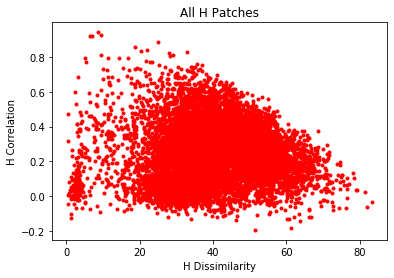

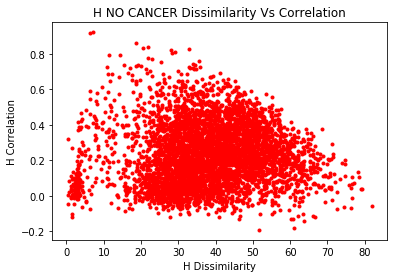

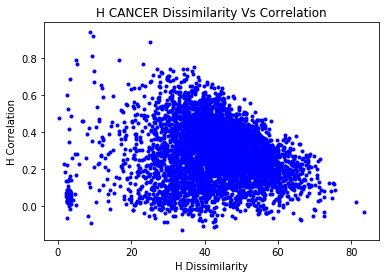

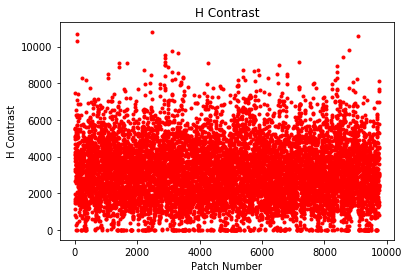

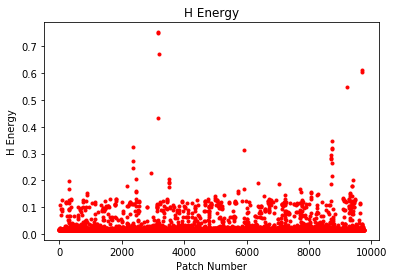

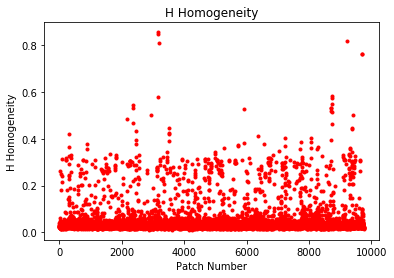

In [29]:
'''
Plot GLCM for H as CANCER & NO CANCER LABELS
'''

if(use_h_glcm_pickle == 1):
    #load the data
    h_glcm_d,h_glcm_c,h_glcm_contrast, h_glcm_energy, h_glcm_homogeneity,h_patch,h_image_names,h_patch_status=pickle.load( open(h_glcm_pickle_file, "rb" ) )
    print('Loaded H GLCM from pickle')
else:
    print('Using inline calculated H GLCM')

#tile_roi_status is the dictionary of filenames with labels
#h_image_names
cancer_label = []

#setup lists to store specific data
h_cancer_c=[]
h_nocancer_c=[]
h_cancer_d=[]
h_nocancer_d = []
h_cancer_energy =[]
h_nocancer_energy =[]
h_cancer_contrast =[]
h_nocancer_contrast =[]
h_cancer_homogeneity =[]
h_nocancer_homogeneity=[]



for ii in range(0,len(h_glcm_c)):
    #go through every row of C,D
    if (h_patch_status[ii] == 1):
        h_cancer_c.append(h_glcm_c[ii])
        h_cancer_d.append(h_glcm_d[ii])
        h_cancer_contrast.append(h_glcm_contrast[ii])
        h_cancer_energy.append(h_glcm_energy[ii])
        h_cancer_homogeneity.append(h_glcm_homogeneity[ii])

    elif (h_patch_status[ii] ==  0):
        #print('status is ',h_patch_status[ii])
        h_nocancer_c.append(h_glcm_c[ii])
        h_nocancer_d.append(h_glcm_d[ii])
        h_nocancer_contrast.append(h_glcm_contrast[ii])
        h_nocancer_energy.append(h_glcm_energy[ii])
        h_nocancer_homogeneity.append(h_glcm_homogeneity[ii])
    else:
        print('DID NOT FIND A STATUS')


#
# Number Statistics
#
print('mean Dissimilarity: ',np.mean(h_glcm_d))
print('mean Correlation: ',np.mean(h_glcm_c))
print('mean Energy: ',np.mean(h_glcm_energy))
print('mean Contrast: ',np.mean(h_glcm_contrast))
print('mean Homogeneity: ', np.mean(h_glcm_homogeneity))

# Cancer Label Statistics
print('Cancer Label Statistics')
print('Cancer Correlation: ',np.mean(h_cancer_c))
print('Cancer Dissimilarity: ',np.mean(h_cancer_d))
print('Cancer Contrast: ',np.mean(h_cancer_contrast))
print('Cancer Energy/Uniformity: ',np.mean(h_cancer_energy))
print('Cancer Homogeneity: ',np.mean(h_cancer_homogeneity))

# No Cancer Label Statistics
print('No Cancer Label Statistics')
print('No Cancer Correlation: ',np.mean(h_nocancer_c))
print('No Cancer Dissimilarity: ',np.mean(h_nocancer_d))
print('No Cancer Contrast: ',np.mean(h_nocancer_contrast))
print('No Cancer Energy: ',np.mean(h_nocancer_energy))
print('No Cancer Homogeneity: ',np.mean(h_nocancer_homogeneity))




#
# Main Plot showing total Corr and Dissim
#
plt.figure()
plt.plot(h_glcm_d, h_glcm_c,'r.')
plt.xlabel('H Dissimilarity')
plt.ylabel('H Correlation')
plt.title('All H Patches')
xaxes = plt.xlim()
yaxes = plt.ylim()
print('x,y axes are ', xaxes, yaxes)




print('Plotting Figs')
plt.figure()
plt.plot(h_nocancer_d, h_nocancer_c,'r.')
plt.xlabel('H Dissimilarity')
plt.ylabel('H Correlation')
plt.title('H NO CANCER Dissimilarity Vs Correlation')


plt.figure()
plt.plot(h_cancer_d, h_cancer_c,'b.')
plt.xlabel('H Dissimilarity')
plt.ylabel('H Correlation')
plt.title('H CANCER Dissimilarity Vs Correlation')


plt.figure()
plt.plot(h_glcm_contrast,'r.')
plt.ylabel('H Contrast')
plt.xlabel('Patch Number')
plt.title('H Contrast')



plt.figure()
plt.plot(h_glcm_energy,'r.')
plt.xlabel('Patch Number')
plt.ylabel('H Energy')
plt.title('H Energy')



plt.figure()
plt.plot(h_glcm_homogeneity,'r.')
plt.xlabel('Patch Number')
plt.ylabel('H Homogeneity')
plt.title('H Homogeneity')

True

Now Writing Percent Stained Eosin Image to GDRIVE:#  0
Now Writing Percent Stained Eosin Image to GDRIVE:#  100
Now Writing Percent Stained Eosin Image to GDRIVE:#  200
Now Writing Percent Stained Eosin Image to GDRIVE:#  300
Now Writing Percent Stained Eosin Image to GDRIVE:#  400
Now Writing Percent Stained Eosin Image to GDRIVE:#  500
Now Writing Percent Stained Eosin Image to GDRIVE:#  600
Now Writing Percent Stained Eosin Image to GDRIVE:#  700
Now Writing Percent Stained Eosin Image to GDRIVE:#  800
Now Writing Percent Stained Eosin Image to GDRIVE:#  900
Eosin GLCM Corr and Dis. pickle file is  /content/gdrive/My Drive/TILE_PREPROCESSING/PICKLE_FILE_E_GLCM.pck
Saved full Eosin CORR & DISS. Data to pickle file


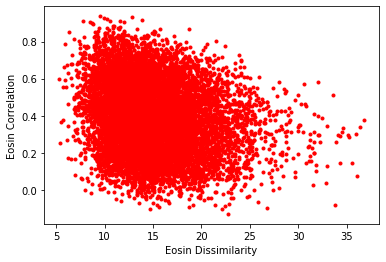

In [0]:
'''
Get patches for Eosin
need: E images, masks or mask centroids
'''
from matplotlib.patches import Rectangle
#
# GLCM
#
from skimage.feature import greycomatrix, greycoprops


#one side dimensions of the patches to cut out
patch_x = 25
patch_y = patch_x
#maximum border entry/exit locations
max_x = 512 - patch_x
min_x = patch_x
max_y = 512 - patch_y
min_y = patch_y
#number of patches/image
num_patches = 15

e_patch = {}
e_glcm_d = []   #store all of the glcm results for glcm
e_glcm_c = []
e_glcm_contrast =[]
e_glcm_energy = []
e_glcm_homogeneity =[]

e_image_names =[] #hold all of the filenames used
e_patch_status =[] #is this patch cancer or not

for ii in range(0,len(deconvolved_image_e)):
    current_image_name = image_names[ii]
    e_image_names.append(current_image_name) #store filename marker

    patch_list = []

    if ((ii % 100) == 0):
        print('Now Writing Percent Stained Eosin Image to GDRIVE:# ', ii)

    #we want patches AWAY from any centroid. Eosin should have contrast areas
    #just below the empty area values of 240+
    eosin_area= np.argwhere((deconvolved_image_e[ii] > 160) & (deconvolved_image_e[ii] < 210))
    num_eosin_areas = len(eosin_area)
    if (num_eosin_areas > 15):
        sample_ids = random.sample(range(0,num_eosin_areas),15)
    else:
        sample_ids = random.sample(range(0,num_eosin_areas),len(num_eosin_areas))
    

    #number_centroids = range(0,len(centroid_xx[ii])) #number of masks in this file
    #if (len(number_centroids) > num_patches):
    #    sample_ids = random.sample(set(number_centroids),num_patches)
    #else:
    #    print('Not enough different centroids available here: ',ii)
    #    continue
    #now that we have centroids to use, get a patch from that
    #make sure we're not using a centroid near an edge that can go outside the
    #image area
    plt.figure() #one figure to hold the patches
    plt.imshow(deconvolved_image_e[ii])
    
    for id in sample_ids:
        #ensure that making a patch abou the centroid won't take us over border
        if ( ((eosin_area[id][0] - patch_x)  >= min_x   ) and ( (eosin_area[id][0] + patch_x) <= max_x) and  
            ((eosin_area[id][1] - patch_y) >= min_y) and ((eosin_area[id][1] + patch_y) <= max_y)):            
        #if (  ((centroid_xx[ii][id] - patch_x) >= min_x) and ( (centroid_xx[ii][id] + patch_x) <= max_x) and 
        #    ((centroid_yy[ii][id] - patch_y) >= min_y) and ((centroid_yy[ii][id] + patch_y) <= max_y)):
            #if this value won't spill over, keep going and get patches
            ax = plt.gca()
            
            # Create a Rectangle patch
            lowerx = eosin_area[id][0] - patch_x
            lowery = eosin_area[id][1] - patch_y

            #lowerx = centroid_xx[ii][id] - patch_x
            #lowery = centroid_yy[ii][id] - patch_y

            boxlength = 50
            rect = Rectangle((lowerx,lowery),boxlength,boxlength,linewidth=2,edgecolor='r',facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)
            

            #ax.plot(centroid_xx[ii][id],centroid_yy[ii][id],'ko',
            #        ms=14,
            #        markerfacecolor="None",
            #        markeredgecolor='k', markeredgewidth=2)
            tname = 'Patches for ' + current_image_name + '\n' + 'Eosin Staining'
            plt.title(tname)


            #store the patch image data
            #center point is centroid, get image data +- xy from this and save
            #that to an array
            patch_data = deconvolved_image_e[ii][np.uint(eosin_area[id][0]-patch_x):np.uint(eosin_area[id][0] + patch_x),
                                                 np.uint(eosin_area[id][1]-patch_y):np.uint(eosin_area[id][1] + patch_y)]
            patch_list.append(patch_data)


        else:
            #this centroid value would have extended out of the image
            #print('border coordinate found. Skipping')
            continue

        #now we should have a set of patches to do GLCM on
        patch_d = []
        patch_corr = []
        patch_contrast=[]
        patch_energy=[]
        patch_homogeneity=[]

        for patch in patch_list:
            glcm = greycomatrix(patch,
                                distances=[5],
                                angles=[0,0.785,2.36],
                                levels=256,
                                symmetric=True,
                                normed=True)
            patch_d.append(greycoprops(glcm, 'dissimilarity')[0, 0])
            patch_corr.append(greycoprops(glcm, 'correlation')[0, 0])
            patch_contrast.append(greycoprops(glcm, 'contrast')[0, 0])
            patch_energy.append(greycoprops(glcm, 'energy')[0, 0])
            patch_homogeneity.append(greycoprops(glcm, 'homogeneity')[0, 0])


    #save all patches
    fname = 'GLCM_Patches_Eosin_' + current_image_name + '.png'
    full_file = os.path.join(patch_review_dir,fname)
    plt.savefig(full_file, format='png',dpi=300, bbox_inches='tight')
    plt.close('all')


    #current_filename = h_image_names[ii]
    cancer_status = int(tile_roi_status[current_image_name])


    e_patch[ii] = patch_list
    #put these into one giant list for plotting
    for kk in patch_d:
        e_glcm_d.append(kk)
        e_patch_status.append(cancer_status)
    for kk in patch_corr:
        e_glcm_c.append(kk)
    for kk in patch_contrast:
        e_glcm_contrast.append(kk)
    for kk in patch_energy:
        e_glcm_energy.append(kk)
    for kk in patch_homogeneity:
        e_glcm_homogeneity.append(kk)


#
# Main Plot showing total Corr and Dissim
#
plt.figure()
plt.plot(e_glcm_d, e_glcm_c,'r.')
plt.xlabel('Eosin Dissimilarity')
plt.ylabel('Eosin Correlation')



#
# Save the data off to disk for review later
#

e_glcm_data = [e_glcm_d,e_glcm_c,e_glcm_contrast, e_glcm_energy, e_glcm_homogeneity,e_patch,e_image_names,e_patch_status]
print('Eosin GLCM Corr and Dis. pickle file is ', e_glcm_pickle_file)
with open(e_glcm_pickle_file, 'wb') as f:
    pickle.dump(e_glcm_data, f)

print('Saved full Eosin CORR & DISS. Data to pickle file')



In [0]:
index[4000]

array([12, 79])

Loaded Eosin GLCM from pickle
mean Dissimilarity:  15.054754762382188
mean Correlation:  0.3895264637509404
mean Energy:  0.027494195157007614
mean Contrast:  432.0405571374461
mean Homogeneity:  0.08026250597318567
Cancer Label Statistics
Cancer Correlation:  0.37211761990074993
Cancer Dissimilarity:  14.988266165480821
Cancer Contrast:  420.5567165167583
Cancer Energy/Uniformity:  0.02666149381782782
Cancer Homogeneity:  0.07815920405835858
No Cancer Label Statistics
No Cancer Correlation:  0.40678930691388876
No Cancer Dissimilarity:  15.12068574724884
No Cancer Contrast:  443.42808759318405
No Cancer Energy:  0.028319912978566494
No Cancer Homogeneity:  0.08234816837514879
yaxes  (-0.18349692057125552, 0.9900429598717774)
xaxes  (3.747222222222221, 38.32877777777777)
Plotting Figs


Text(0.5, 1.0, 'E Homogeneity')

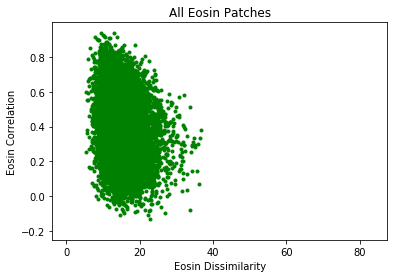

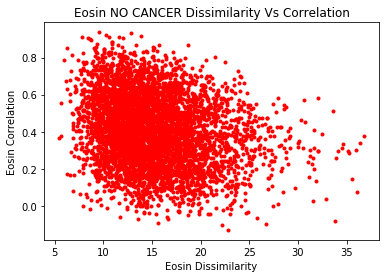

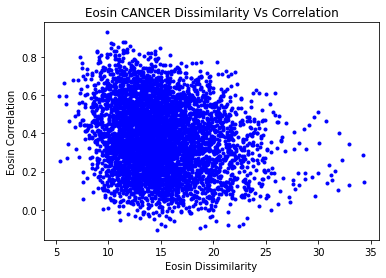

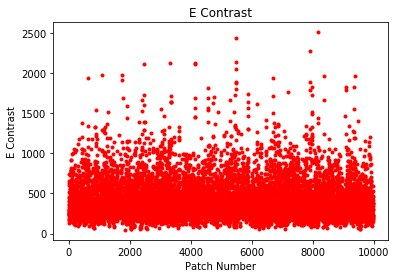

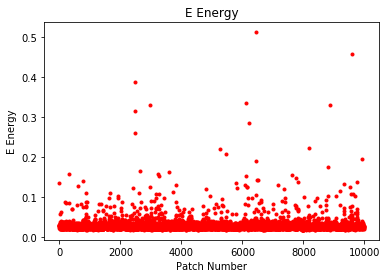

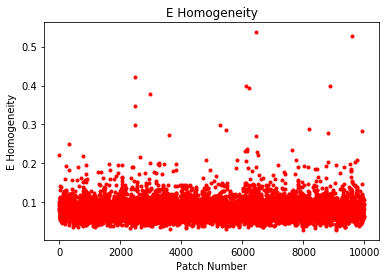

In [30]:
'''
Plot GLCM for Eosin as CANCER & NO CANCER LABELS
'''


if(use_e_glcm_pickle == 1):
    #load the data
    e_glcm_d,e_glcm_c,e_glcm_contrast, e_glcm_energy,e_glcm_homogeneity,e_patch,e_image_names,e_patch_status=pickle.load( open(e_glcm_pickle_file, "rb" ) )
    print('Loaded Eosin GLCM from pickle')
else:
    print('Using inline calculated Eosin GLCM')


#tile_roi_status is the dictionary of filenames with labels
#h_image_names
cancer_label = []

#setup lists to store specific data
e_cancer_c=[]
e_nocancer_c=[]
e_cancer_d=[]
e_nocancer_d = []

e_cancer_energy =[]
e_nocancer_energy =[]
e_cancer_contrast =[]
e_nocancer_contrast =[]
e_cancer_homogeneity =[]
e_nocancer_homogeneity=[]



for ii in range(0,len(e_glcm_c)):
    #go through every row of C,D
    if (e_patch_status[ii] == 1):
        e_cancer_c.append(e_glcm_c[ii])
        e_cancer_d.append(e_glcm_d[ii])
        e_cancer_energy.append(e_glcm_energy[ii])
        e_cancer_contrast.append(e_glcm_contrast[ii])
        e_cancer_homogeneity.append(e_glcm_homogeneity[ii])


    elif (e_patch_status[ii] ==  0):
        #print('status is ',h_patch_status[ii])
        e_nocancer_c.append(e_glcm_c[ii])
        e_nocancer_d.append(e_glcm_d[ii])
        e_nocancer_energy.append(e_glcm_energy[ii])
        e_nocancer_contrast.append(e_glcm_contrast[ii])
        e_nocancer_homogeneity.append(e_glcm_homogeneity[ii])
    else:
        print('DID NOT FIND A STATUS')


#
# Number Statistics
#
print('mean Dissimilarity: ',np.mean(e_glcm_d))
print('mean Correlation: ',np.mean(e_glcm_c))
print('mean Energy: ',np.mean(e_glcm_energy))
print('mean Contrast: ',np.mean(e_glcm_contrast))
print('mean Homogeneity: ',np.mean(e_glcm_homogeneity))

# Cancer Label Statistics
print('Cancer Label Statistics')
print('Cancer Correlation: ',np.mean(e_cancer_c))
print('Cancer Dissimilarity: ',np.mean(e_cancer_d))
print('Cancer Contrast: ',np.mean(e_cancer_contrast))
print('Cancer Energy/Uniformity: ',np.mean(e_cancer_energy))
print('Cancer Homogeneity: ',np.mean(e_cancer_homogeneity))

# No Cancer Label Statistics
print('No Cancer Label Statistics')
print('No Cancer Correlation: ',np.mean(e_nocancer_c))
print('No Cancer Dissimilarity: ',np.mean(e_nocancer_d))
print('No Cancer Contrast: ',np.mean(e_nocancer_contrast))
print('No Cancer Energy: ',np.mean(e_nocancer_energy))
print('No Cancer Homogeneity: ',np.mean(e_nocancer_homogeneity))



#
# Main Plot showing total Corr and Dissim for all patches over all images
#
plt.figure()
plt.plot(e_glcm_d, e_glcm_c,'g.')
plt.xlabel('Eosin Dissimilarity')
plt.ylabel('Eosin Correlation')
plt.title('All Eosin Patches')
yaxes = plt.ylim()
xaxes = plt.xlim()
#-3.831311111111106, 87.53664444444433
plt.ylim(-0.24946794956061796, 0.9978587963990962)
plt.xlim(-3.831311111111106, 87.53664444444433)
print('yaxes ', yaxes)
print('xaxes ',xaxes)



print('Plotting Figs')
plt.figure()
plt.plot(e_nocancer_d, e_nocancer_c,'r.')
plt.xlabel('Eosin Dissimilarity')
plt.ylabel('Eosin Correlation')
plt.title('Eosin NO CANCER Dissimilarity Vs Correlation')


plt.figure()
plt.plot(e_cancer_d, e_cancer_c,'b.')
plt.xlabel('Eosin Dissimilarity')
plt.ylabel('Eosin Correlation')
plt.title('Eosin CANCER Dissimilarity Vs Correlation')


plt.figure()
plt.plot(e_glcm_contrast,'r.')
plt.ylabel('E Contrast')
plt.xlabel('Patch Number')
plt.title('E Contrast')



plt.figure()
plt.plot(e_glcm_energy,'r.')
plt.xlabel('Patch Number')
plt.ylabel('E Energy')
plt.title('E Energy')



plt.figure()
plt.plot(e_glcm_homogeneity,'r.')
plt.xlabel('Patch Number')
plt.ylabel('E Homogeneity')
plt.title('E Homogeneity')
